## Introducción

En este laboratorio aplicaré un árbol de decisión para predecir el fármaco óptimo según parámetros de salud de pacientes, enfocándome en:

1. Preparar y entender los datos.
2. Entrenar el modelo.
3. Visualizar su estructura.
4. Evaluar su rendimiento con métricas clave.

### Cargar librerías

In [28]:
!pip install numpy==2.2.0
!pip install pandas==2.2.3
!pip install scikit-learn==1.6.0
!pip install matplotlib==3.9.3


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [29]:
import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn import metrics

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

### Sobre el conjunto de datos

Se obtuvo información de pacientes con la misma enfermedad y su respuesta a cinco fármacos: A, B, C, X y Y.

* **Características**: Edad, Sexo, Presión arterial y Colesterol.
* **Objetivo**: El medicamento al que cada paciente respondió.

Este conjunto servirá para entrenar un clasificador multiclasem (árbol de decisión) y predecir qué fármaco podría ser el más adecuado para un nuevo paciente.



### Descarga de datos

In [30]:
url = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/Module%203/data/drug200.csv'
datos = pd.read_csv(url)
datos

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,drugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,drugY
...,...,...,...,...,...,...
195,56,F,LOW,HIGH,11.567,drugC
196,16,M,LOW,HIGH,12.006,drugC
197,52,M,NORMAL,HIGH,9.894,drugX
198,23,M,NORMAL,NORMAL,14.020,drugX


## Análisis y preprocesamiento de datos
Para entender mejor los datos, aplicaré pasos básicos. Primero, obtendré información general del dataset.

In [31]:
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          200 non-null    int64  
 1   Sex          200 non-null    object 
 2   BP           200 non-null    object 
 3   Cholesterol  200 non-null    object 
 4   Na_to_K      200 non-null    float64
 5   Drug         200 non-null    object 
dtypes: float64(1), int64(1), object(4)
memory usage: 9.5+ KB


Esto revela que 4 de las 6 características del conjunto son categóricas, por lo que debo convertirlas a valores numéricos. Para ello usaré `LabelEncoder` de Scikit-Learn:


In [32]:
# Convierto variables categóricas a numéricas
le = LabelEncoder()
for columna in ['Sex', 'BP', 'Cholesterol']:
    datos[columna] = le.fit_transform(datos[columna])

# Mostrar los primeros registros para verificar
datos.head()

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,0,0,0,25.355,drugY
1,47,1,1,0,13.093,drugC
2,47,1,1,0,10.114,drugC
3,28,0,2,0,7.798,drugX
4,61,0,1,0,18.043,drugY


Con esto ya tengo 5 variables predictoras y 1 objetivo. La codificación queda así:

- **Sex**: M → 1, F → 0  
- **BP**: High → 0, Low → 1, Normal → 2  
- **Cholesterol**: High → 0, Normal → 1  


Revisar si hay valores nulos en cada columna

In [33]:
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          200 non-null    int64  
 1   Sex          200 non-null    int64  
 2   BP           200 non-null    int64  
 3   Cholesterol  200 non-null    int64  
 4   Na_to_K      200 non-null    float64
 5   Drug         200 non-null    object 
dtypes: float64(1), int64(4), object(1)
memory usage: 9.5+ KB


In [34]:
datos.isnull().sum()

Age            0
Sex            0
BP             0
Cholesterol    0
Na_to_K        0
Drug           0
dtype: int64

Esto indica que no hay valores faltantes en ninguna columna.

Para evaluar la correlación entre la variable objetivo y las características, conviene asignar valores numéricos a cada fármaco. Ejecuta la siguiente celda:


In [35]:
custom_map = {'drugA':0,'drugB':1,'drugC':2,'drugX':3,'drugY':4}
datos['Drug_num'] = datos['Drug'].map(custom_map)
datos

,Age,Sex,BP,Cholesterol,Na_to_K,Drug,Drug_num
0,23,0,0,0,25.355,drugY,4
1,47,1,1,0,13.093,drugC,2
2,47,1,1,0,10.114,drugC,2
3,28,0,2,0,7.798,drugX,3
4,61,0,1,0,18.043,drugY,4
...,...,...,...,...,...,...,...
195,56,0,1,0,11.567,drugC,2
196,16,1,1,0,12.006,drugC,2
197,52,1,2,0,9.894,drugX,3
198,23,1,2,1,14.020,drugX,3


In [36]:
# Calcular y ordenar por |correlación|
corr_target = datos.drop('Drug', axis=1) \
                   .corr()['Drug_num'] \
                   .abs() \
                   .sort_values(ascending=False)

print(corr_target)

Drug_num       1.000000
Na_to_K        0.589120
BP             0.372868
Sex            0.098573
Cholesterol    0.055629
Age            0.004828
Name: Drug_num, dtype: float64


Podemos visualizar la distribución del dataset graficando la cantidad de registros para cada fármaco.

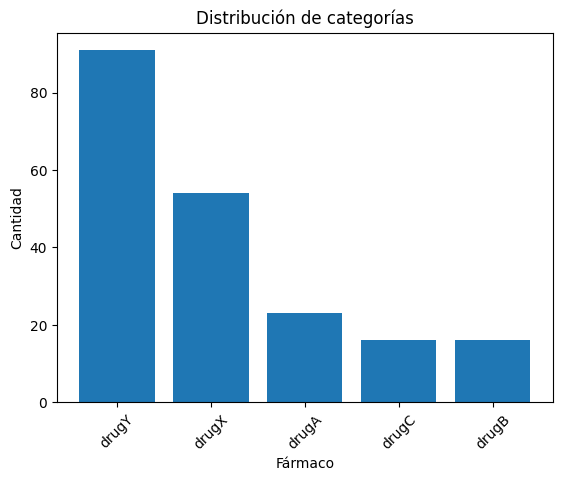

In [37]:
# Conteo de registros por fármaco
category_counts = my_data['Drug'].value_counts()

plt.bar(category_counts.index, category_counts.values)
plt.xlabel('Fármaco')
plt.ylabel('Cantidad')
plt.title('Distribución de categorías')
plt.xticks(rotation=45)  # Rotar etiquetas si es necesario
plt.show()

Esto evidencia que Drug X y Drug Y tienen muchas más muestras que el resto de los fármacos.

## Modelado


Para entrenar un clasificador de árboles de decisión, primero separamos la variable objetivo de las variables de entrada y luego dividimos el conjunto en datos de entrenamiento y de prueba:

In [39]:
y = datos['Drug']
X = datos.drop(['Drug','Drug_num'], axis=1)

Dividimos el conjunto: 30% para prueba y 70% para entrenamiento

In [40]:
X_trainset, X_testset, y_trainset, y_testset = train_test_split(X, y, test_size=0.3, random_state=32)

Ahora podemos definir el clasificador de árbol de decisión como __drugTree__ y entrenarlo con los datos de entrenamiento.

In [41]:
drugTree = DecisionTreeClassifier(criterion="entropy", max_depth = 4)

In [42]:
drugTree.fit(X_trainset,y_trainset)

DecisionTreeClassifier(criterion='entropy', max_depth=4)

### Evalucacion


Ahora que entrnemamos el árbol de decisión, podemos usarlo para generar las predicciones en el conjunto de prueba.

In [43]:
tree_predictions = drugTree.predict(X_testset)

Ahora podemos evaluar el accuracy de nuestro modelo usando la métrica de precisión.


In [44]:
print("Accuracy: ", metrics.accuracy_score(y_testset, tree_predictions))

Accuracy:  0.9833333333333333


Esto significa que el modelo pudo identificar correctamente el 98.33 % de las etiquetas, es decir, 59 de las 60 muestras de prueba.

### Visualizar el Arbol

Para comprender los criterios de clasificación derivados por el árbol de decisión, podemos generar su diagrama.


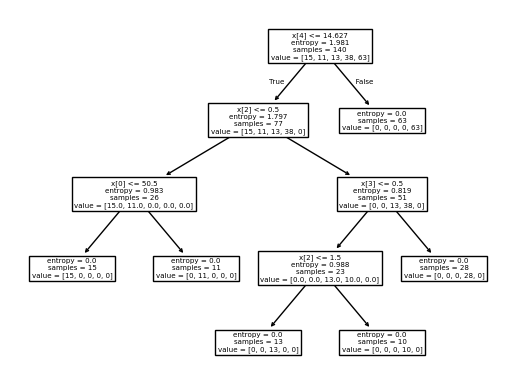

In [45]:
plot_tree(drugTree)
plt.show()

### Criterios de decisión para cada clase

Para extraer todas las reglas que el árbol usa para clasificar en cada una de las 5 clases, usamos `export_text` de Scikit-Learn y luego leer cada hoja (leaf):

In [48]:
from sklearn.tree import export_text

reglas = export_text(drugTree, feature_names=list(X.columns))
print(reglas)

|--- Na_to_K <= 14.63
|   |--- BP <= 0.50
|   |   |--- Age <= 50.50
|   |   |   |--- class: drugA
|   |   |--- Age >  50.50
|   |   |   |--- class: drugB
|   |--- BP >  0.50
|   |   |--- Cholesterol <= 0.50
|   |   |   |--- class: drugC
|   |   |--- Cholesterol >  0.50
|   |   |   |--- class: drugX
|--- Na_to_K >  14.63
|   |--- class: drugY

